In [1]:
#hide
from fastai.data.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastcore.all import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from fastai.vision.all import *
import random
from torch.utils.data import SubsetRandomSampler

# Load your data (assuming a DataBlock and DataLoaders are already defined)
# Using df_train and df_test from your previous code as the dataset
dblock = DataBlock(
    blocks=(ImageBlock(PILImageBW), CategoryBlock),
    get_x=ColReader('image'),
    get_y=ColReader('label'),
    splitter=RandomSplitter(valid_pct=0.2),
    item_tfms=Resize(28),
    batch_tfms=aug_transforms()
)

# Specify batch size and number of samples per epoch (subset size)
batch_size = 64
subset_size = 500  # e.g., use 500 samples per epoch

# Define a function that creates a SubsetRandomSampler for each epoch
def get_subset_sampler(dataset, subset_size):
    indices = list(range(len(dataset)))  # All indices of the dataset
    random.shuffle(indices)  # Shuffle them to randomize sampling
    subset_indices = indices[:subset_size]  # Take a random subset of the desired size
    return SubsetRandomSampler(subset_indices)

# Create the data loaders with a custom sampler for each epoch
def create_dataloaders(subset_size, batch_size):
    # Create the train and validation datasets
    train_dataset = dblock.datasets(df_train)[0]
    valid_dataset = dblock.datasets(df_train)[1]
    
    # Create DataLoaders with a SubsetRandomSampler for the training set
    train_dl = DataLoader(train_dataset, batch_size=batch_size, sampler=get_subset_sampler(train_dataset, subset_size))
    valid_dl = DataLoader(valid_dataset, batch_size=batch_size)  # Use default sampler for validation
    
    return train_dl, valid_dl

# Get DataLoaders with subset sampling
train_dl, valid_dl = create_dataloaders(subset_size, batch_size)

# Combine into a DataLoaders object for Fastai
dls = DataLoaders(train_dl, valid_dl)

# Train the model using a ResNet architecture
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3)

# Show some results
learn.show_results()


# From Model to Production

Now, we're going to use a computer vision example to look at the end-to-end process of creating a deep learning application. 

More specifically, we're going to build a bear classifier! In the process, we'll discuss the capabilities and constraints of deep learning, explore how to create datasets, look at possible gotchas when using deep learning in practice, and more. Many of the key points will apply equally well to other deep learning problems.

Let's start with how you should frame your problem.

## The Practice of Deep Learning

### Starting a Project

When starting a project, the most important consideration is data availability. The goal is not to find the "perfect" dataset, but just to get started and iterate from there.

Also, iterate from end to end in your project; that is, don't spend months fine-tuning your model, or polishing the perfect GUI, or labelling the perfect dataset… Instead, complete every step as well as you can in a reasonable amount of time, all the way to the end. 

By using the end-to-end iteration approach you will also get a better understanding of how much data you really need. For instance, you may find you can only easily get 200 labeled data items, and you can't really know until you try whether that's enough to get the performance you need for your application to work well in practice.


### The Drivetrain Approach

The Drivetrain Approach was described in detail in ["Designing Great Data Products"](https://www.oreilly.com/radar/drivetrain-approach-data-products/). The basic idea is to start with considering your objective, then think about what actions you can take to meet that objective and what data you have (or can acquire) that can help, and then build a model that you can use to determine the best actions to take to get the best results in terms of your objective.

<img src="images/Lesson2_drivetrain-approach.png" id="drivetrain" caption="The Drivetrain Approach">

In practice, often the practical implementation of your models will require a lot more than just training a model! You'll often need to run experiments to collect more data, and consider how to incorporate your models into the overall system you're developing.

## Gathering Data

For many types of projects, you may be able to find all the data you need online. The project we'll be completing in this chapter is a *bear detector*. It will discriminate between three types of bear: grizzly, black, and teddy bears. There are many images on the internet of each type of bear that we can use. We just need a way to find them and download them. 

# clean


In [2]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search

In [3]:
from duckduckgo_search import ddg_images

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
results = search_images('grizzly bear', max_images=150)
ims = results.attrgot('contentUrl')
len(ims)

90

In [5]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [6]:
from fastdownload import download_url
dest = 'images/Lesson2_grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

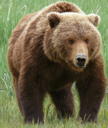

In [7]:
im = Image.open(dest)
im.to_thumb(128,128)

Let's download all the URLs for each of our search terms. We'll put each in a separate folder:

In [8]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [9]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        results = search_images(f'{o} bear')
        download_images(dest, urls=results)

Our folder has image files, as we'd expect:

In [10]:
fns = get_image_files(path)
fns

(#247) [Path('bears/black/00bc93ef-3e37-4732-a5a3-ec29acd2e04a.jpg'),Path('bears/black/021afcc3-7af5-488d-932e-267478aa7259.jpg'),Path('bears/black/04c6cebd-81b9-44e8-8633-4b6372dd6d62.jpg'),Path('bears/black/0790114d-5c84-40a7-b011-2cf1db7387c6.jpg'),Path('bears/black/09c57b91-733d-45f0-a858-2fdf5f00ccaf.jpg'),Path('bears/black/0b9deac8-900a-4b19-9252-489c5f24ab6f.jpg'),Path('bears/black/0bf9448d-60cc-426d-a774-78de7c9249dc.jpg'),Path('bears/black/1745c0a0-5e14-4ffe-9363-38a6c5196b0f.jpg'),Path('bears/black/1805c2e6-b81e-4182-b715-5c2e467fd4f1.jpg'),Path('bears/black/18c7b87b-9a34-48ca-90a8-dac406e70d2a.jpg')...]

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [11]:
failed = verify_images(fns)
len(failed)

0

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [12]:
failed.map(Path.unlink);

One thing to be aware of in this process: models can only reflect the data used to train them. And the world is full of biased data. For instance, let's say you were interested in creating an app that could help users figure out whether they had healthy skin, so you trained a model on the results of searches for (say) "healthy skin." 

<img src="images/Lesson2_healthy_skin.gif" width="600" caption="Data for a healthy skin detector?" id="healthy_skin">

With this as your training data, you would end up not with a healthy skin detector, but a *young white woman touching her face* detector! Be sure to think carefully about the types of data that you might expect to see in practice in your application, and check carefully to ensure that all these types are reflected in your model's source data. 


Now that we have downloaded some data, we need to assemble it in a format suitable for model training. In fastai, that means creating an object called `DataLoaders`.

## From Data to DataLoaders

`DataLoaders` is a thin class that just stores whatever `DataLoader` objects you pass to it, and makes them available as `train` and `valid`. Although it's a very simple class, it's very important in fastai: it provides the data for your model. The key functionality in `DataLoaders` is provided with just these four lines of code (it has some other minor functionality we'll skip over for now):

```python
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])
```

> DataLoaders: A fastai class that stores multiple `DataLoader` objects you pass to it, normally a `train` and a `valid`, although it's possible to have as many as you like. The first two are made available as properties.

To turn our downloaded data into a `DataLoaders` object we need to tell fastai at least four things:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

So far we have seen a number of *factory methods* for particular combinations of these things, which are convenient when you have an application and data structure that happen to fit into those predefined methods. For when you don't, fastai has an extremely flexible system called the *data block API*. With this API you can fully customize every stage of the creation of your `DataLoaders`. Here is what we need to create a `DataLoaders` for the dataset that we just downloaded:

In [13]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Let's look at each of these arguments in turn. First we provide a tuple where we specify what types we want for the independent and dependent variables: 

```python
blocks=(ImageBlock, CategoryBlock)
```

The *independent variable* is the thing we are using to make predictions from, and the *dependent variable* is our target. In this case, our independent variables are images, and our dependent variables are the categories (type of bear) for each image. 

For this `DataLoaders` our underlying items will be file paths. We have to tell fastai how to get a list of those files. The `get_image_files` function takes a path, and returns a list of all of the images in that path (recursively, by default):

```python
get_items=get_image_files
```

Often, datasets that you download will already have a validation set defined. Sometimes this is done by placing the images for the training and validation sets into different folders. Sometimes it is done by providing a CSV file in which each filename is listed along with which dataset it should be in. There are many ways that this can be done, and fastai provides a very general approach that allows you to use one of its predefined classes for this, or to write your own. In this case, however, we simply want to split our training and validation sets randomly. However, we would like to have the same training/validation split each time we run this notebook, so we fix the random seed (computers don't really know how to create random numbers at all, but simply create lists of numbers that look random; if you provide the same starting point for that list each time—called the *seed*—then you will get the exact same list each time):


```python
splitter=RandomSplitter(valid_pct=0.2, seed=42)
```

The independent variable is often referred to as `x` and the dependent variable is often referred to as `y`. Here, we are telling fastai what function to call to create the labels in our dataset:

```python
get_y=parent_label
```

`parent_label` is a function provided by fastai that simply gets the name of the folder a file is in. Because we put each of our bear images into folders based on the type of bear, this is going to give us the labels that we need.

Our images are all different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several of them (what we call a *mini-batch*). To group them in a big array (usually called a *tensor*) that is going to go through our model, they all need to be of the same size. So, we need to add a transform which will resize these images to the same size. *Item transforms* are pieces of code that run on each individual item, whether it be an image, category, or so forth. fastai includes many predefined transforms; we use the `Resize` transform here:

```python
item_tfms=Resize(128)
```

This command has given us a `DataBlock` object. This is like a *template* for creating a `DataLoaders`. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [14]:
dls = bears.dataloaders(path)

A `DataLoaders` includes validation and training `DataLoader`s. `DataLoader` is a class that provides batches of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a `DataLoader` fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a `DataLoader`:

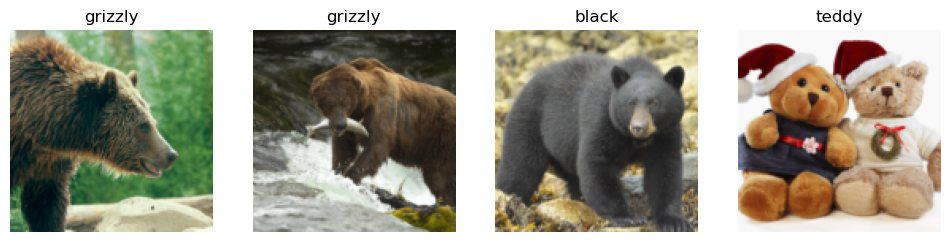

In [15]:
dls.valid.show_batch(max_n=4, nrows=1)

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

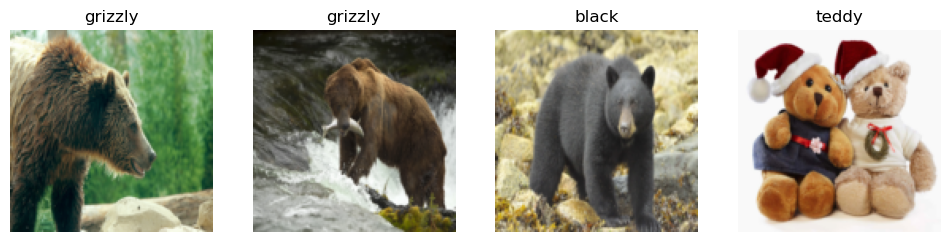

In [16]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

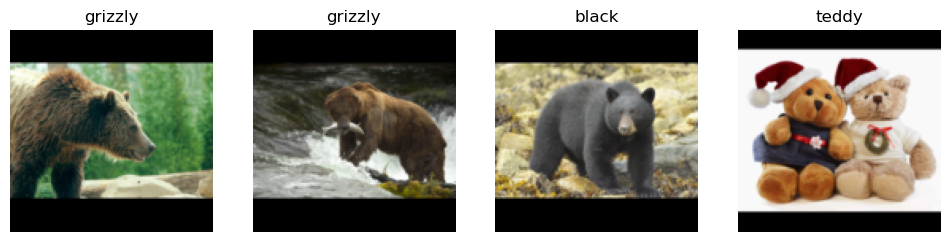

In [17]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

All of these approaches seem somewhat wasteful, or problematic. If we squish or stretch the images they end up as unrealistic shapes, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. If we crop the images then we remove some of the features that allow us to perform recognition. For instance, if we were trying to recognize breeds of dog or cat, we might end up cropping out a key part of the body or the face necessary to distinguish between similar breeds. If we pad the images then we have a whole lot of empty space, which is just wasted computation for our model and results in a lower effective resolution for the part of the image we actually use.

Instead, what we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

In fact, an entirely untrained neural network knows nothing whatsoever about how images behave. It doesn't even recognize that when an object is rotated by one degree, it still is a picture of the same thing! So actually training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

Here's another example where we replace `Resize` with `RandomResizedCrop`, which is the transform that provides the behavior we just described. The most important parameter to pass in is `min_scale`, which determines how much of the image to select at minimum each time:

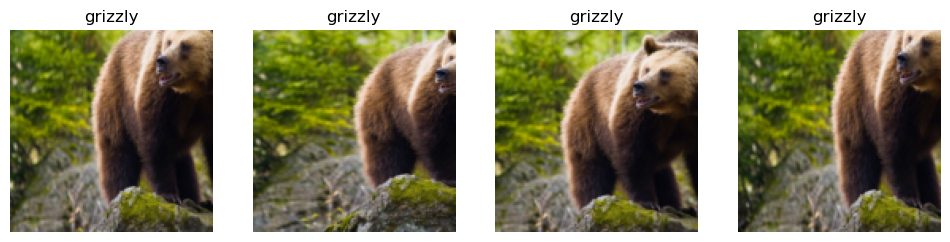

In [18]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

We used `unique=True` to have the same image repeated with different versions of this `RandomResizedCrop` transform. This is a specific example of a more general technique, called data augmentation.

### Data Augmentation

*Data augmentation* refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the `aug_transforms` function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the `batch_tfms` parameter (note that we're not using `RandomResizedCrop` in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):

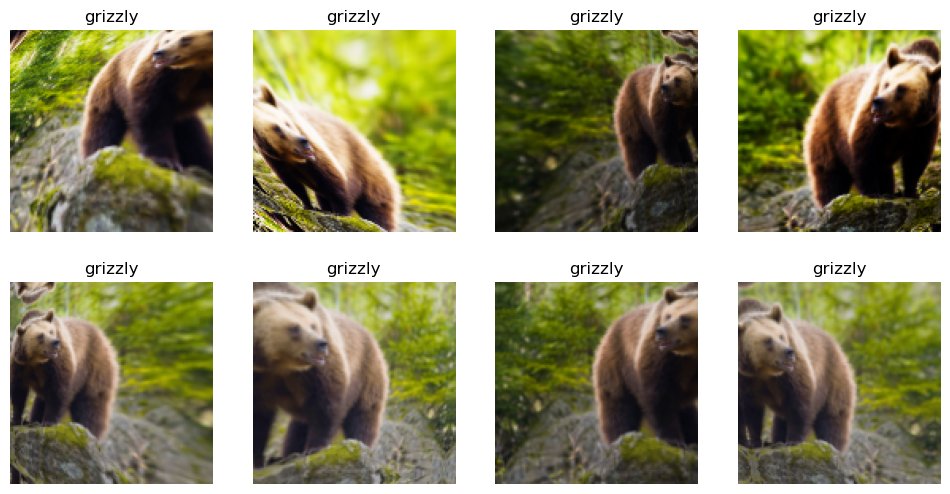

In [19]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now that we have assembled our data in a format fit for model training, let's actually train an image classifier using it.

## Training Your Model, and Using It to Clean Your Data

Time to train our bear classifier.

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [20]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [21]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.595897,0.375348,0.204082,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.421246,0.069953,0.000000,00:23
1,0.268115,0.015024,0.000000,00:24
2,0.189476,0.003365,0.000000,00:24
3,0.148491,0.002474,0.000000,00:23


Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a *confusion matrix*:

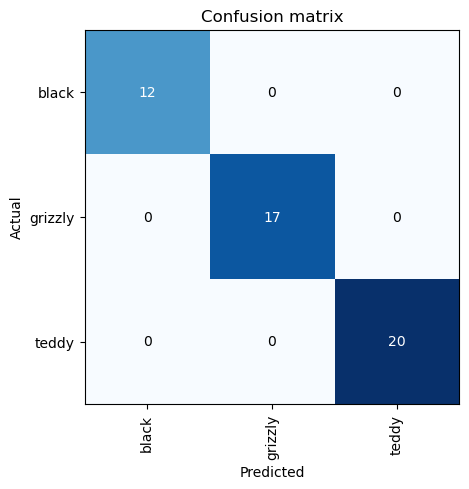

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The rows represent all the black, grizzly, and teddy bears in our dataset, respectively. The columns represent the images which the model predicted as black, grizzly, and teddy bears, respectively. Therefore, the diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly. This is one of the many ways that fastai allows you to view the results of your model. It is (of course!) calculated using the validation set. With the color-coding, the goal is to have white everywhere except the diagonal, where we want dark blue. Our bear classifier isn't making many mistakes!

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't bears at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their *loss*.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. In a couple of chapters we'll learn in depth how loss is calculated and used in the training process. For now, `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction:

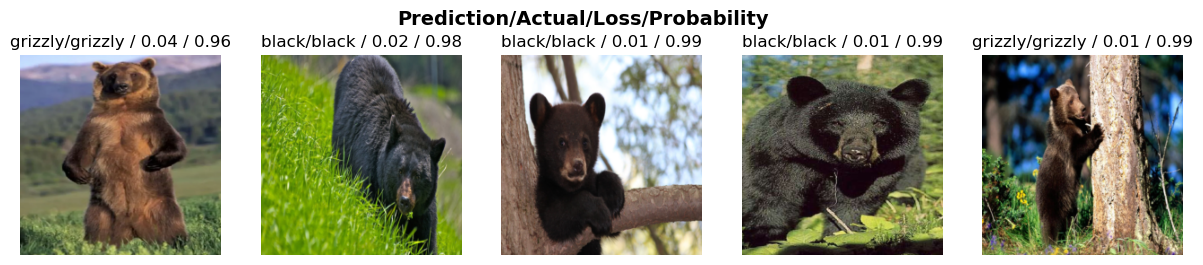

In [23]:
interp.plot_top_losses(5, nrows=1)

This output shows that the image with the highest loss is one that has been predicted as "grizzly" with high confidence. However, it's labeled (based on our image search) as "black." We're not bear experts, but it sure looks to us like this label is incorrect! We should probably change its label to "grizzly."

The intuitive approach to doing data cleaning is to do it *before* you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [24]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

<img alt="Cleaner widget" width="700" src="images/Lesson2_att_00007.png">

In [25]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

We can see that amongst our "black bears" is an image that contains two bears: one grizzly, one black. So, we should choose `<Delete>` in the menu under this image. `ImageClassifierCleaner` doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change. So, for instance, to delete (`unlink`) all images selected for deletion, we would run:

```python
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
```

To move images for which we've selected a different category, we would run:

```python
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```

> Cleaning the data and getting it ready for your model are two of the biggest challenges for data scientists; they say it takes 90% of their time. 

Once we've cleaned up our data, we can retrain our model and see that the accuracy improves!

>No Need for Big Data: After cleaning the dataset using these steps, we generally are seeing 100% accuracy on this task. We even see that result when we download a lot fewer images than the 150 per class we're using here. As you can see, the common complaint that _you need massive amounts of data to do deep learning_ can be a very long way from the truth!

Now that we have trained our model, let's see how we can deploy it to be used in practice.

### Using the Model for Inference

Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the *architecture* and the trained *parameters*. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the `export` method.

This method even saves the definition of how to create your `DataLoaders`. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set `DataLoader` for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call `export`, fastai will save a file called "export.pkl":

In [29]:
learn.export(path/'bears.pkl')

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [31]:
learn_inf = load_learner(path/'bears.pkl')

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

In [32]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([2.0220e-06, 1.0000e+00, 3.1610e-07]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [33]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

## Out-of-domain data

One of the biggest issues to consider is that understanding and testing the behavior of a deep learning model is much more difficult than with most other code you write. With normal software development you can analyze the exact steps that the software is taking, and carefully study which of these steps match the desired behavior that you are trying to create. But with a neural network the behavior emerges from the model's attempt to match the training data, rather than being exactly defined.

This can result in disaster! For instance, let's say we really were rolling out a bear detection system that will be attached to video cameras around campsites in national parks, and will warn campers of incoming bears. If we used a model trained with the dataset we downloaded there would be all kinds of problems in practice, such as:

- Working with video data instead of images
- Handling nighttime images, which may not appear in this dataset
- Dealing with low-resolution camera images
- Ensuring results are returned fast enough to be useful in practice
- Recognizing bears in positions that are rarely seen in photos that people post online (for example from behind, partially covered by bushes, or when a long way away from the camera)

A big part of the issue is that the kinds of photos that people are most likely to upload to the internet are the kinds of photos that do a good job of clearly and artistically displaying their subject matter—which isn't the kind of input this system is going to be getting. So, we may need to do a lot of our own data collection and labelling to create a useful system.

This is just one example of the more general problem of *out-of-domain* data. That is to say, there may be data that our model sees in production which is very different to what it saw during training. There isn't really a complete technical solution to this problem; instead, we have to be careful about our approach to rolling out the technology.

There are other reasons we need to be careful too. One very common problem is *domain shift*, where the type of data that our model sees changes over time. For instance, an insurance company may use a deep learning model as part of its pricing and risk algorithm, but over time the types of customers that the company attracts, and the types of risks they represent, may change so much that the original training data is no longer relevant.

Out-of-domain data and domain shift are examples of a larger problem: that you can never fully understand the entire behaviour of your neural network. They have far too many parameters to be able to analytically understand all of their possible behaviors. This is the natural downside of their best feature—their flexibility, which enables them to solve complex problems where we may not even be able to fully specify our preferred solution approaches. The good news, however, is that there are ways to mitigate these risks using a carefully thought-out process.

<img alt="Deployment process" width="500" caption="Deployment process" id="deploy_process" src="images/Lesson2_att_00061.png">